
<div dir="rtl" align="right">

## تکلیف

محاسبه‌ی پذیرفتاری مغناطیسی

تکلیف مدل آیزینگ

# افزودن میدان مغناطیسی خارجی به مدل آیزینگ

برای افزودن یک میدان مغناطیسی خارجی \( h \)، ترم جدیدی به هامیلتونی اضافه می‌شود:

$$
H = -J \sum_{\langle i,j \rangle} S_i S_j - h \sum_i S_i
$$

- $ h $: میدان مغناطیسی خارجی.
- $ \sum_i S_i $: مجموع تمامی اسپین‌ها در سیستم.

---

# **محاسبه‌ی مغناطش متوسط (Magnetization)**

مغناطش \( M \) به صورت میانگین مجموع اسپین‌ها تعریف می‌شود:

$$
M = \frac{1}{N} \sum_i S_i
$$

که در آن \( N \) تعداد اسپین‌ها در سیستم است.

---

# **محاسبه‌ی پذیرفتاری مغناطیسی (Magnetic Susceptibility)**

حساسیت مغناطیسی $\chi$ نشان‌دهنده‌ی پاسخ سیستم به تغییرات میدان مغناطیسی خارجی است و به صورت زیر تعریف می‌شود:

$$
\chi = \frac{\partial M}{\partial h}
$$

این کمیت را می‌توان به صورت نوسانات مغناطش نیز بیان کرد:

$$
\chi = \frac{1}{kT} \left( \langle M^2 \rangle - \langle M \rangle^2 \right)
$$

که در آن:
- $ k $: ثابت بولتزمان.
- $ T $: دما.
- $ \langle M \rangle $: میانگین مغناطش.
- $ \langle M^2 \rangle $: میانگین مربع مغناطش.

---

+++

- با استفاده از مقادیر مغناطش، حساسیت مغناطیسی $ \chi $ را محاسبه کنید.
- تغییرات $ \chi $ را بر حسب دما $ T $ و میدان مغناطیسی $ h $ بررسی کنید.
</div>

In [15]:
import tqdm
import tqdm.contrib
import tqdm.contrib.concurrent
import numpy as np
import matplotlib.pyplot  as plt
from scipy.ndimage import convolve
from concurrent.futures import ThreadPoolExecutor

In [16]:
class IsingModel(np.ndarray):
    def __new__(cls , N , *args , **kwargs ):
        obj = np.random.choice([1 , -1] , size=[N,N] ).view(cls)
        return obj

    def __array_finalize__(self , obj):
        if obj is None: return

    def __init__(self , N):
        self.N = N
        self.h = 1  #External Field
        self._filter = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
        self._neighbors = convolve(self , self.filter , mode='wrap')

    @property
    def magnetization(self):
        return float(np.sum(self))/self.N

    @property
    def filter(self):
        return self._filter

    @property
    def neighbors(self):
        return self._neighbors

    @property
    def energy(self):
        return float(-0.5 * np.sum(self*self.neighbors) - self.h * np.sum(self))

    def monte_carlo_step(self, temperature: float, external_field: float) -> bool:
        """
            Perform a single Monte Carlo sweep with sequential spin updates.
            Returns the number of accepted spin flips.    
        """
        i = np.random.randint(0, self.N-1)
        j = np.random.randint(0, self.N-1)

        # Calculate the energy change if this spin is flipped
        delta_E = 2 * self[i, j] * self.neighbors[i, j] + 2 * self[i, j] * external_field
        # Apply Metropolis criterion
        if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / temperature):
            self[i, j] *= -1  # Flip the spin
            # Update the n_sum matrix around the (i, j) element
            self._neighbors[ i+1 % self.N , j] += 2 * self[i, j]
            self._neighbors[ i-1 , j] += 2 * self[i, j]
            self._neighbors[ i , j+1 % self.N] += 2 * self[i, j]
            self._neighbors[ i , j-1] += 2 * self[i, j]
            return True
        return False

In [44]:
N_Size = 10
def simulate_ising_model(T, h , N=N_Size , steps_to_equilibrium = 2000 , steps_to_average = 10000):
    M, A = np.zeros(steps_to_average), np.zeros(steps_to_average)
    
    model = IsingModel(N)
    for i in range(steps_to_equilibrium):
        model.monte_carlo_step(T, h)

    for i in range(steps_to_average):
        res = model.monte_carlo_step(T, h)
        M[i] = model.magnetization
        A[i] = res

    return T, h, M, A

temperatures = np.linspace(0.1, 4.1, 10)
magnetic_field = np.linspace(0.01, 0.51, 10)

N_Simulations = 20
with ThreadPoolExecutor() as executor:
    temp_results = list(tqdm.contrib.concurrent.thread_map(simulate_ising_model, np.repeat(temperatures, N_Simulations), np.zeros(200)))
    mag_results = list(tqdm.contrib.concurrent.thread_map(simulate_ising_model, np.ones(200), np.repeat(magnetic_field, N_Simulations)))

100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


In [ ]:
M_avg_temp = np.mean([temp_results[i][2] for i in range(200)], axis=1)
M2_avg_temp = np.mean([temp_results[i][2]**2 for i in range(200)], axis=1)

M_avg_mag = np.mean([mag_results[i][2] for i in range(200)], axis=1)
M2_avg_mag = np.mean([mag_results[i][2]**2 for i in range(200)], axis=1)

susceptibility_temp = (M2_avg_temp - M_avg_temp**2) / np.repeat(temperatures, N_Simulations)
susceptibility_mag = (M2_avg_mag - M_avg_mag**2) / np.repeat(magnetic_field, N_Simulations)

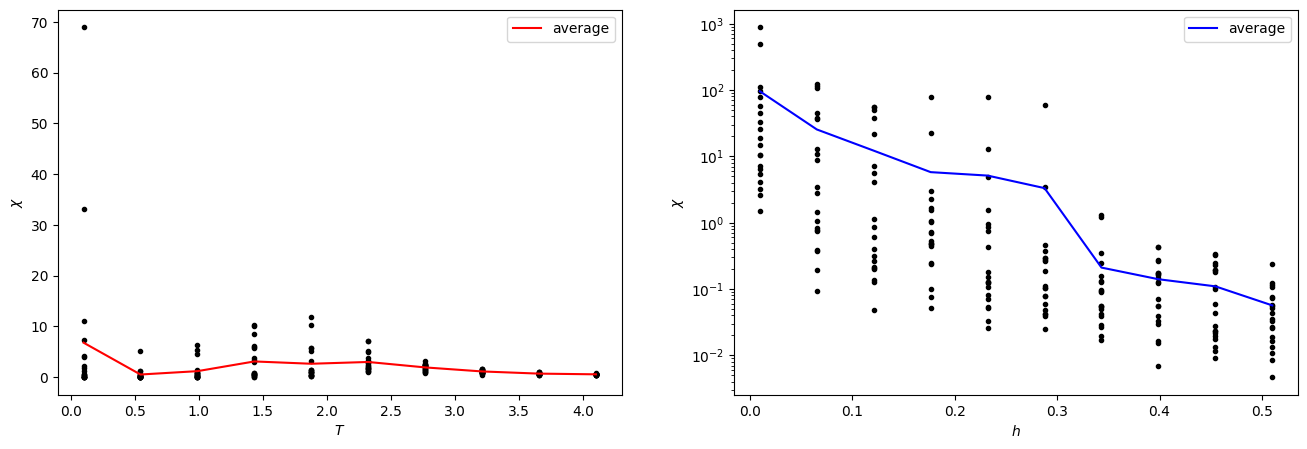

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(temperatures, susceptibility_temp.reshape(10, 20), 'k.')
axs[0].plot(temperatures, np.mean(susceptibility_temp.reshape(10, 20), axis=1), 'r', label='average')
axs[0].set_xlabel(r"$T$")
axs[0].set_ylabel(r"$\chi$")
axs[0].legend()

axs[1].semilogy(magnetic_field, susceptibility_mag.reshape(10, 20), 'k.')
axs[1].semilogy(magnetic_field, np.mean(susceptibility_mag.reshape(10, 20), axis=1), 'b', label='average')
axs[1].set_xlabel(r"$h$")
axs[1].set_ylabel(r"$\chi$")
axs[1].legend()
plt.show()

<div dir="rtl" align="right">
از شکل‌های بالا پیداست، پذیرفتاری مغناطیسی به شدت به میدان مغناطیسی خارجی حساس است و با افزایش آن به سرعت افت می‌کند. همچنین با اینکه پذیرفتاری مغناطیسی به دما به اندازه‌ی میدان خارجی حساس نیست، ولی با افزایش دما، تغییرات در پذیرفتاری مغناطیسی کاهش می‌یابد و به یک مقدار کمینه میل می‌کند.